In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import random
import pickle


from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size' : 14})

In [4]:
# Let's create a function to display the coefficient of determination on the graph.
def evalute_preds(train_true_values, train_preds_values, test_true_values, test_pred_values):
    """
    Displays the coefficient of determination on the test and training samples and displays it on the graph.
    """
    plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.scatterplot(x=train_preds_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    plt.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    
    return 'Train R2:\t' + str(round(r2(train_true_values, train_preds_values), 3)),
    'Test R2:\t' + str(round(r2(train_true_values, train_preds_values), 3))

In [5]:
# Creating constans fot training and test samples
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Описание датасета
* __Id__ - Идентификационный номер квартиры
* __Districtld__ - Идентификационный номер района
* __Rooms__ - количество комнат
* __Square___ - общая площадь
* __LifeSquare__ - жилая площадь
* __KitchenSquare__ - площадь кухни
* __Floor__ - этаж
* __HouseFloor__ - количество этажей в доме
* __HouseYear__ - год постройки
* __Ecolgy_1, Ecology_2, Ecology_3__ - экологические показатели месности
* __Social_1, Social_2, Social_3__ - социальные показатели местности
* __Healtcare_1, Healtcare_2__ - показатели местности, связанные с охраной здоровья
* __Shops_1, Shpos_2__ - показатели, связанные с наличием магазинов, торговых центров
* __Price__ - цены на квартиры

In [7]:
# Loading the feature space
X = pd.read_csv(TRAIN_DATASET_PATH)
X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [8]:
# Selecting a target variable
y = X['Price']
y

0       184966.930730
1       300009.450063
2       220925.908524
3       175616.227217
4       150226.531644
            ...      
9995    196684.316040
9996    189050.289571
9997    159143.805370
9998    181595.339808
9999    218714.077615
Name: Price, Length: 10000, dtype: float64

Text(0, 0.5, '')

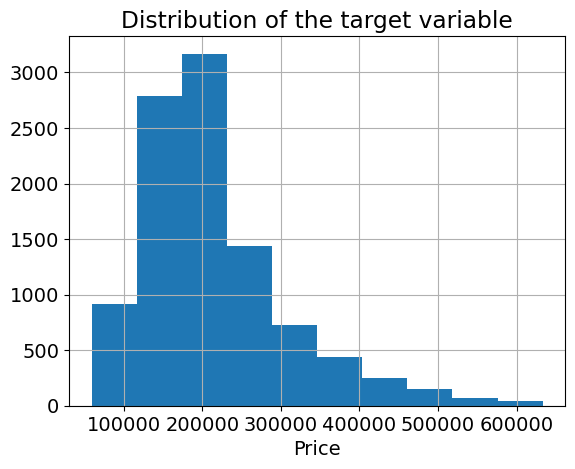

In [9]:
# Distribution of the target variable
y.hist()
plt.title('Distribution of the target variable')
plt.xlabel('Price')
plt.ylabel('')

The distribution is lognormal.

<Axes: >

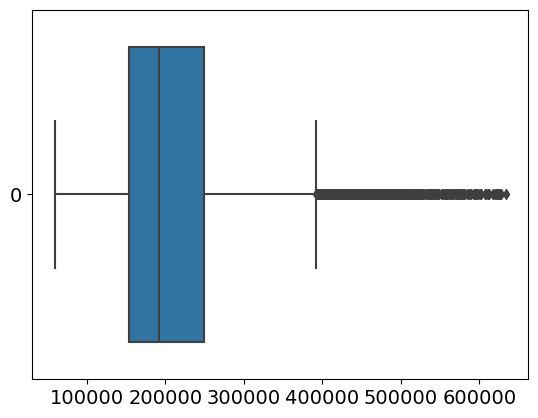

In [11]:
# Let's look at the outliers of the target variable
sns.boxplot(y, orient="h")

Boxplot clearly shows outliers when the cost of an apartment is above 390_000 thousand. To normalize the distribution, the outliers will be replaced by the median.

In [13]:
# Let's define the maximum boxplot
q3 = np.quantile(y, 0.75)
q1 = np.quantile(y, 0.25)
IQR = q3 - q1
boxplot_max = q3 + 1.5*IQR
boxplot_max

392029.7045148853

In [14]:
# Replacing the outliers with the median.
y[y > boxplot_max] = y.median()

Text(0, 0.5, '')

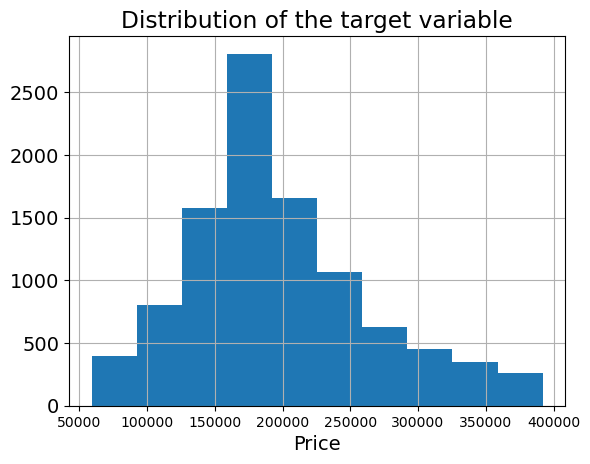

In [15]:
# Distribution of the target variable after outlier processing.
y.hist(xlabelsize=10)
plt.title('Distribution of the target variable')
plt.xlabel('Price')
plt.ylabel('')

In [16]:
# Let's check the empty values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

There are no values in this dataset. These are the signs: Life Square and Healthcare_1. The Health_1 attribute will be deleted because almost 50% of the data is missing. And the empty values of the LifeSquare attribute will be replaced by the median. Because it is less affected by emissions.

In [18]:
# Deleting selected features.
X.drop(columns=['Id','Price', 'Healthcare_1'], axis=1, inplace=True)
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,3,11,B
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,0,5,A
9997,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,0,0,A
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,2,5,B


Let's remove the target variable from the feature space. We will remove the non-informative Id attribute, as well as the Healthcare_1 attribute.

In [20]:
# Replace the empty values in the LifeSquare attributes with the median
LifeSquare = X['Square'] - X['KitchenSquare']
X['LifeSquare'].fillna(LifeSquare, inplace=True)

In [21]:
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,3,11,B
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,0,5,A
9997,27,1.0,47.939008,46.939008,1.0,12,16.0,2015,0.072158,B,B,2,629,1,0,0,A
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,2,5,B


array([[<Axes: title={'center': 'DistrictId'}>,
        <Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Square'}>,
        <Axes: title={'center': 'LifeSquare'}>],
       [<Axes: title={'center': 'KitchenSquare'}>,
        <Axes: title={'center': 'Floor'}>,
        <Axes: title={'center': 'HouseFloor'}>,
        <Axes: title={'center': 'HouseYear'}>],
       [<Axes: title={'center': 'Ecology_1'}>,
        <Axes: title={'center': 'Social_1'}>,
        <Axes: title={'center': 'Social_2'}>,
        <Axes: title={'center': 'Social_3'}>],
       [<Axes: title={'center': 'Helthcare_2'}>,
        <Axes: title={'center': 'Shops_1'}>, <Axes: >, <Axes: >]],
      dtype=object)

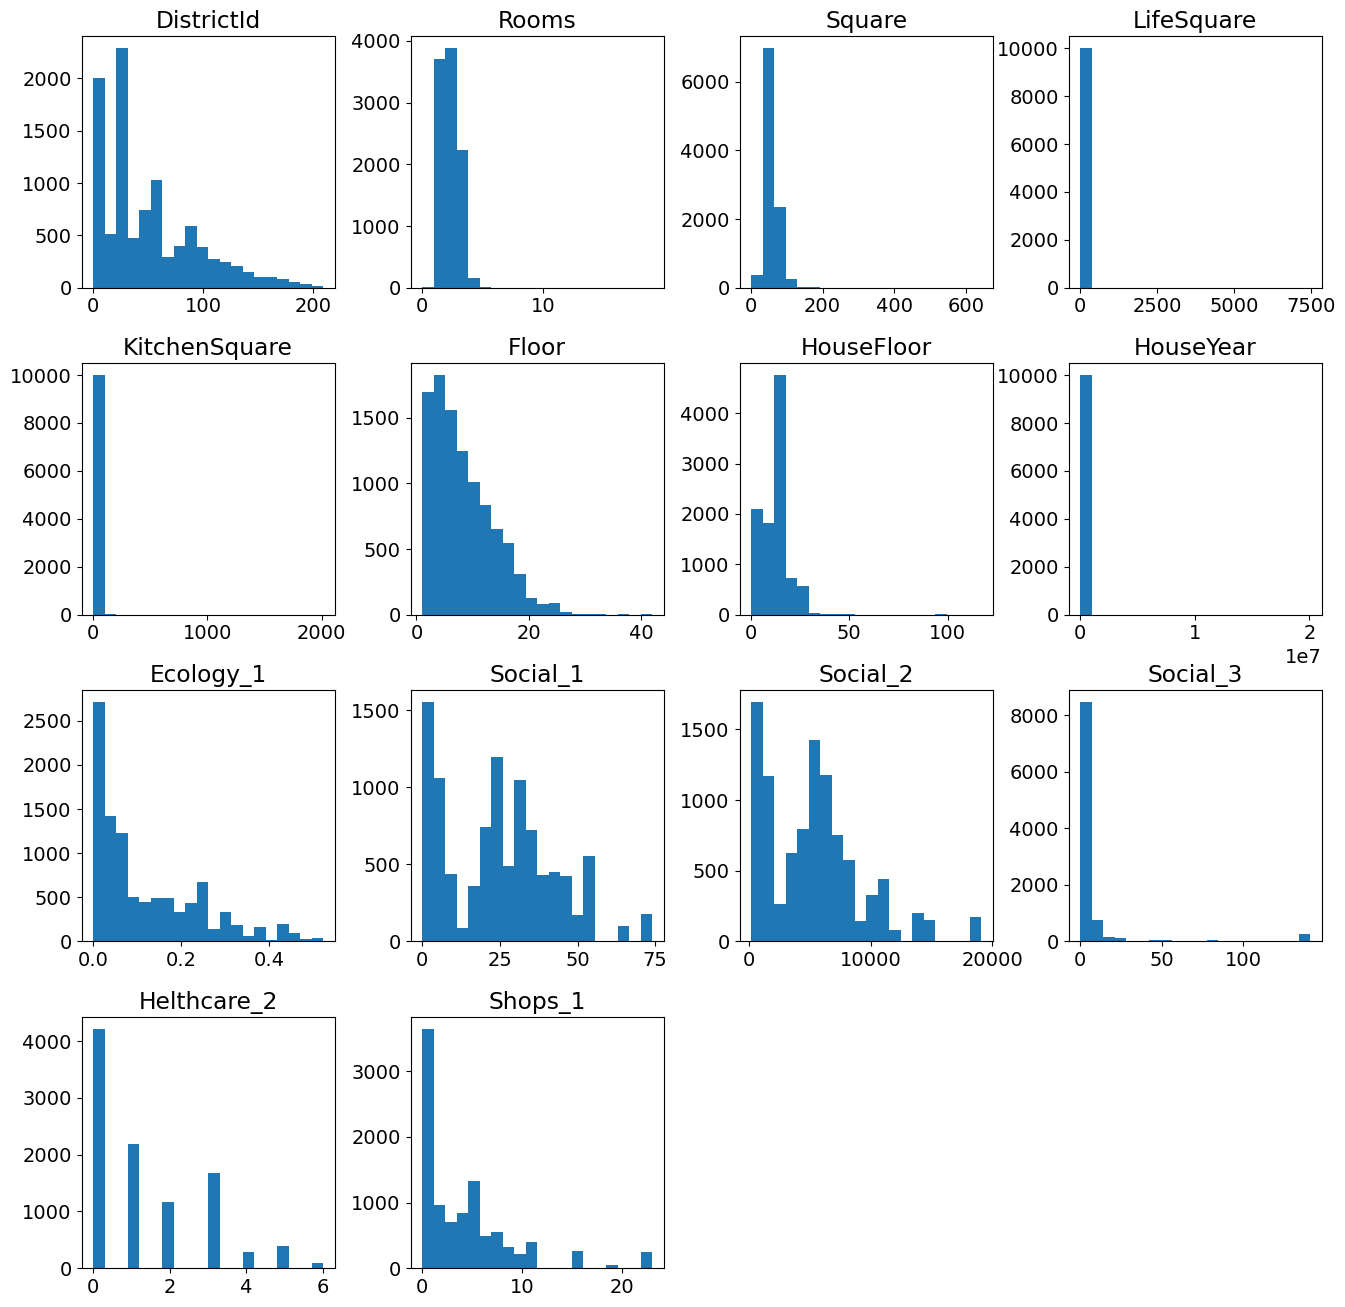

In [22]:
# Let's look at the distributions of all the signs
X.hist(figsize=(16, 16), bins=20, grid=False)

In [23]:
# Let's look at the descriptive statistics
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,41.799474,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300
std,43.587592,0.839512,21.058732,77.823543,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774881,25.494155,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513310,37.040829,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900625,49.823229,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000


As we can see from the descriptive statistics. The minima and maxima of the signs: Rooms, Square, Life Square, KitchenSquare, House Floor do not correspond to reality, these signs will be reduced to absolute values.

In [25]:
# Calculate the minimum boxplot
def min_boxplot(sing):
    """
    This function calculates the minimum boundary of the boxplot distribution
    """
    q3 = np.quantile(X['Square'], 0.75)
    q1 = np.quantile(X['Square'], 0.25)
    IQR = q3 - q1
    boxplot_min = q1 - 1.5*IQR
    
    return boxplot_min

In [26]:
# Calculate the maximum boxplot
def max_boxplot(sing):
    """
    This function calculates the maximum boundary of the boxplot distribution
    """
    
    q3 = np.quantile(X['Square'], 0.75)
    q1 = np.quantile(X['Square'], 0.25)
    IQR = q3 - q1
    boxplot_max = q3 + 1.5*IQR
    
    return boxplot_max

### Pricessing of the Rooms attribute

In [28]:
# Let's look at all the values of the rooms
X['Rooms'].value_counts()

Rooms
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: count, dtype: int64

In [29]:
# Replace the values of rooms that are greater than 6. Replace with the median.
X['Rooms'][X['Rooms'] > 6] = X['Rooms'].median()

<Axes: >

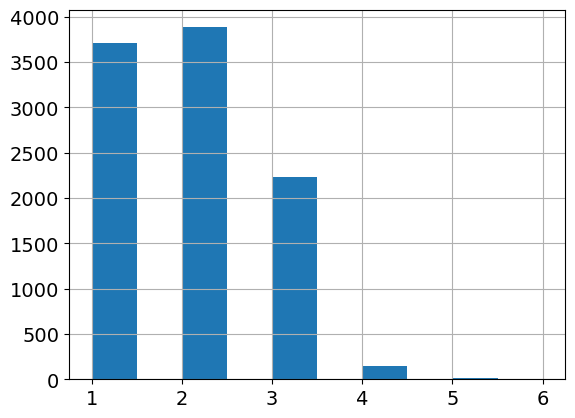

In [30]:
# Replace the zero value of the number of rooms with 1
X['Rooms'][X['Rooms'] == 0] = 1
X['Rooms'].hist()

In [31]:
# Output of the processed attribute
X['Rooms'].value_counts()

Rooms
2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: count, dtype: int64

### Pricessing of the Square attribute

In [33]:
# Let's process the maximum and minimum emissions of the Square attribute
X['Square'][X['Square'] < min_boxplot(X['Square'])] = X['Square'].median()
X['Square'][X['Square'] > max_boxplot(X['Square'])] = X['Square'].median()

(array([  14.,  170., 1746., 2578., 1747., 1634.,  699.,  947.,  326.,
         139.]),
 array([ 13.78486476,  22.6120751 ,  31.43928545,  40.26649579,
         49.09370613,  57.92091648,  66.74812682,  75.57533716,
         84.4025475 ,  93.22975785, 102.05696819]),
 <BarContainer object of 10 artists>)

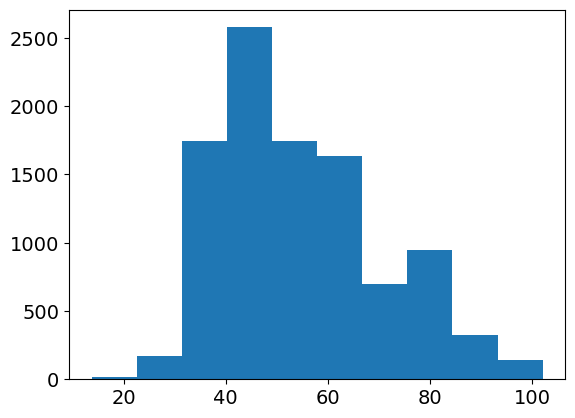

In [34]:
# Let's build a histogram after processing the data
plt.hist(X['Square'])

As we can see, the histogram has taken on a more normalized appearance.

### Pricessing of the KitchenSquare attribute

<Axes: >

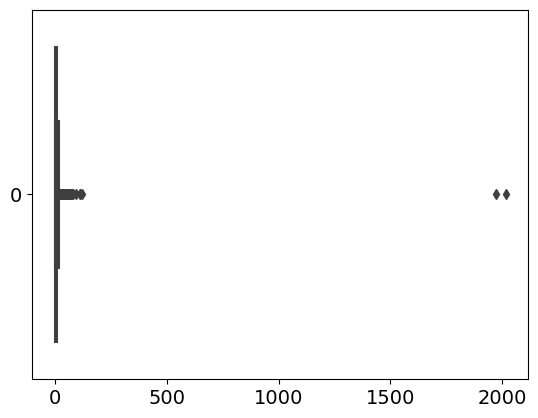

In [36]:
# Let's build a boxplot to determine outliers
sns.boxplot(X['KitchenSquare'], orient='h')

In [37]:
# Let's process the maximum and minimum emissions of the KitchenSquare attribute
X['KitchenSquare'][X['KitchenSquare'] < 4] = 4
X['KitchenSquare'][X['KitchenSquare'] > max_boxplot(X['KitchenSquare'])] = X['KitchenSquare'].median()

The value of 4 "square meters" was taken from google sources.

<Axes: >

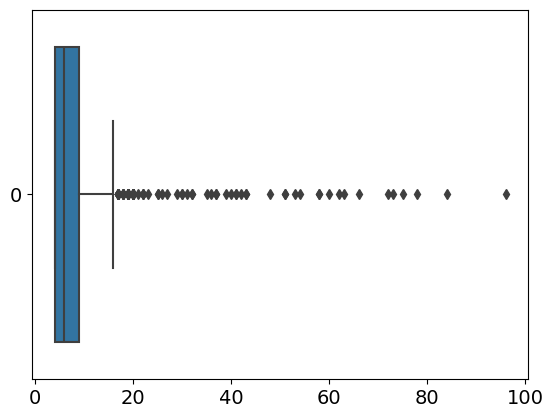

In [38]:
# Let's build a boxplot after processing the data
sns.boxplot(X['KitchenSquare'], orient='h')

This graph shows that there are no emissions

### Pricessing of the LifeSquare attribute

<Axes: >

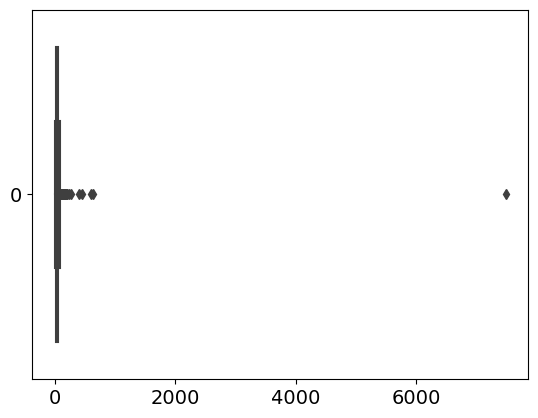

In [41]:
# Let's build a boxplot to determine outliers
sns.boxplot(X['LifeSquare'], orient='h')

In [42]:
# Let's find the boundaries of the boxplot
max_boxplot(X['LifeSquare']), min_boxplot(X['LifeSquare'])

(99.01577061350542, 7.461564644595114)

In [98]:
# Let's process the maximum and minimum emissions of the LifeSquare attribute
X['LifeSquare'][X['LifeSquare'] > max_boxplot(X['LifeSquare'])] = X['LifeSquare'].median()
X['LifeSquare'][X['LifeSquare'] < min_boxplot(X['LifeSquare'])] = X['LifeSquare'].median()

<Axes: >

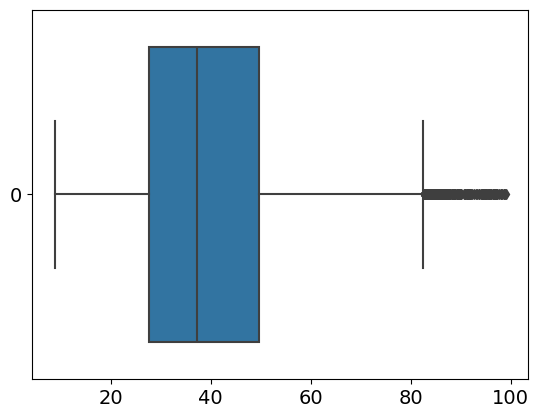

In [100]:
# Let's build a boxplot after processing the data
sns.boxplot(X['LifeSquare'], orient='h')

In [104]:
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888000,54.654787,40.756167,6.863000,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300
std,43.587592,0.812479,15.859585,17.456400,3.874472,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341
min,0.000000,1.000000,13.784865,8.822988,4.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.794392,27.613399,4.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513445,37.284241,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000
75%,75.000000,2.000000,64.682943,49.592317,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000
max,209.000000,6.000000,102.056968,98.994909,96.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000


In [45]:
# Replacing string values with unique numeric values
for field_name in list(X):
  if isinstance(X[field_name].unique()[0], str):
    for item, i in enumerate(list(X[field_name].unique())):
      if isinstance(i, str):
        X.loc[X[field_name] == i, field_name] = int(item)
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0
2,53,2.0,44.947953,29.197612,4.0,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,0,0,46,7960,6,3,11,0
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,0,0,30,5562,0,0,5,1
9997,27,1.0,47.939008,46.939008,4.0,12,16.0,2015,0.072158,0,0,2,629,1,0,0,1
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,0,1,30,5048,9,2,5,0


In [46]:
np.quantile(X['KitchenSquare'], 0.75)

9.0

In [47]:
q3 = np.quantile(X['Rooms'], 0.75)
q1 = np.quantile(X['Rooms'], 0.25)
IQR = q3 - q1
boxplot_min = q3 + 1.5*IQR
boxplot_min

3.5

In [48]:
 np.quantile(X['Rooms'], 0.975)

3.0